## Klasyfikacja ręcznie pisanych liczb - MNIST

Po wykonaniu poprzedniego zadania zleceniodawca znów zadzwonił do Ciebie z kolejnym zadaniem. Okazuje się, że nie wszystkie informacje trafiły do zbioru Tytanic. Brakowało w nim między innymi informacji o pokojach w których mieszkali pasażerowie. Wszystkie informacje o miejscu spania były bowiem zapisane odręcznie na kartkach. Tajemniczy  więc zlecił Ci nowe zadanie... **Stworzenie konwolucyjnej sieci neuronowej rozpoznającej ręcznie pisane cyfry.**

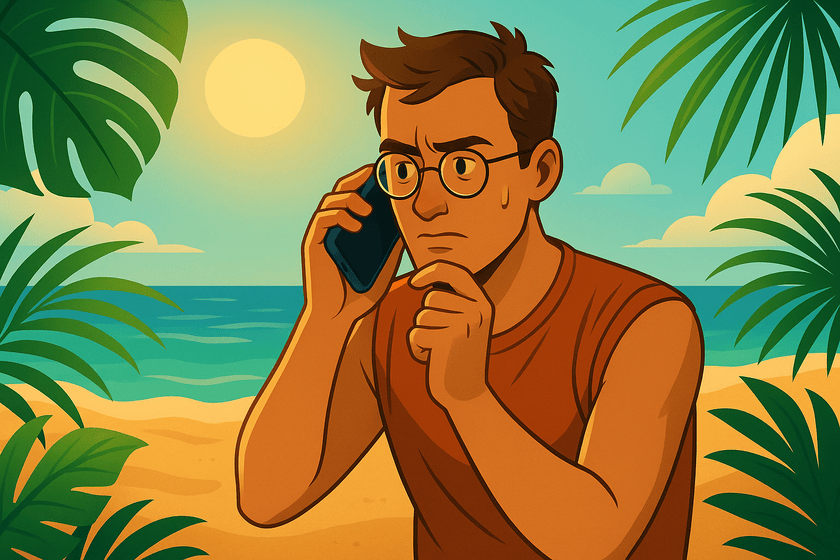

(*AI-generated image*)


#### Twoim celem będzie jest wytrenowanie modelu widzenia komputerowego (CNN) do klasyfikacji każdej ręcznie pisanej liczby z jak najlepszą dokładnością.

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Co mój model robi i w jaki sposób?
- Na czym skupia się mój model?
- Jakie liczby mój model myli? Dlaczego?
- Jak uodpornić mój model?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Spróbuj dobrać strukture sieci (szerokość i wysokość) i sprawdź jaki ma wpływ na dokładność
- Ćwiczenie: zmień liczbę kanałów/warstw, dodaj BatchNorm, spróbuj zwiększyć/zmniejszyć dropout.
- Wypisz wnioski.
- Korzystaj z `PyTorch` (`torch, torchvision`)

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


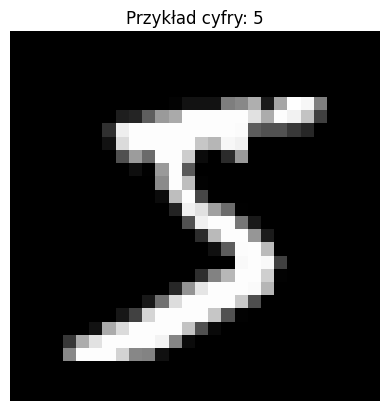

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


plt.imshow(x_train[0], cmap='gray')
plt.title(f"Przykład cyfry: {y_train[0]}")
plt.axis('off')
plt.show()

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import time
import os
import random

In [3]:
SEED = 42 # he he 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

data_root = "./data"
train_full = datasets.MNIST(root=data_root, train=True, download=True, transform=transform)
test_ds    = datasets.MNIST(root=data_root, train=False, download=True, transform=transform)

val_size = 5000
train_size = len(train_full) - val_size
train_ds, val_ds = random_split(train_full, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(val_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 34.2MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.02MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.73MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.88MB/s]


(55000, 5000, 10000)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


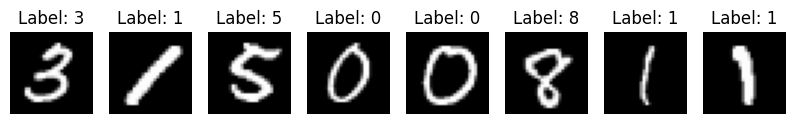

In [5]:
images, labels = next(iter(train_loader))
images = images[:8]
labels = labels[:8]

fig, axes = plt.subplots(1, len(images), figsize=(10, 6))
for ax, img, lab in zip(axes, images, labels):
    ax.imshow(img.squeeze().numpy(), cmap="gray")
    ax.set_title(f"Label: {lab.item()}")
    ax.axis("off")
plt.show()

Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie zwykła sieć (nie musi być na wszystkich próbkach - zajmie to długo)

No to tworzymy prosty MLP żeby z ciekawości zobaczyć i pozniej porównać wyniki

#  Prosty MLP - Model 1

In [6]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size = 256, output_size= 10):

        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)


    def forward(self, x):

        x = x.view(x.size(0), -1) # model linearny więc trzeba to dać zeby się poradził z obrazkami
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x

model1 = SimpleMLP().to(device)

No i uczymy model w pętli treningowej

In [7]:
def run_epoch(loader, train: bool, model, optimizer=None, criterion=None):

  # jak epochy wpływają na wynik?
    epoch_loss, correct, total = 0.0, 0, 0
    if train:
        model.train()
    else:
        model.eval()
    for xb, yb in loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        if train:
            optimizer.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(xb)
            loss = criterion(logits, yb)
            if train:
                loss.backward()
                optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
        preds = logits.argmax(1)
        correct += (preds == yb).sum().item()
        total += yb.size(0)
    return epoch_loss / total, correct / total

Dalej  robimy loss calculation i train. W tym przypadku CrossEntropyLoss ponieważ jest lepsza właśnie dla modelu kategorizacji (czyli własnie nasz przypadek)

In [8]:
from torch.optim import Adam
def train(model, val_loader,train_loader):
  EPOCHS = 5
  lr = 1e-3

  optimizer = Adam(model.parameters(), lr=lr)
  criterion = nn.CrossEntropyLoss()
  history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
  start = time.time()
  for epoch in range(1, EPOCHS+1):
      tr_loss, tr_acc = run_epoch(train_loader, train=True, model=model, optimizer=optimizer, criterion=criterion)
      va_loss, va_acc = run_epoch(val_loader, train=False, model=model,  optimizer=optimizer, criterion=criterion)
      history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
      history["val_loss"].append(va_loss);   history["val_acc"].append(va_acc)
      print(f"Ep {epoch:02d}/{EPOCHS} | train loss {tr_loss:.4f} acc {tr_acc:.4f} | val loss {va_loss:.4f} acc {va_acc:.4f}")
  print(f"Czas treningu: {time.time()-start:.1f}s")

  return history

Rysujemy wykresiki dla śledzenia przebiegu uczenia się modelu

Wykres strat

In [9]:
 def loss_plot(history):
    plt.figure(figsize=(6,6))
    plt.plot(history["train_loss"], label="train loss")
    plt.plot(history["val_loss"], label="val loss")
    plt.xlabel("Epoka")
    plt.ylabel("Strata")
    plt.legend()
    plt.show()

Wykres accuracy

In [10]:
 def acc_plot(history):
    plt.figure(figsize=(6,4))
    plt.plot(history["train_acc"], label="train acc")
    plt.plot(history["val_acc"], label="val acc")
    plt.xlabel("Epoka")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

Ep 01/5 | train loss 0.2784 acc 0.9184 | val loss 0.1556 acc 0.9528
Ep 02/5 | train loss 0.1155 acc 0.9665 | val loss 0.1077 acc 0.9672
Ep 03/5 | train loss 0.0763 acc 0.9769 | val loss 0.0947 acc 0.9704
Ep 04/5 | train loss 0.0551 acc 0.9835 | val loss 0.0855 acc 0.9726
Ep 05/5 | train loss 0.0419 acc 0.9870 | val loss 0.0799 acc 0.9740
Czas treningu: 75.7s


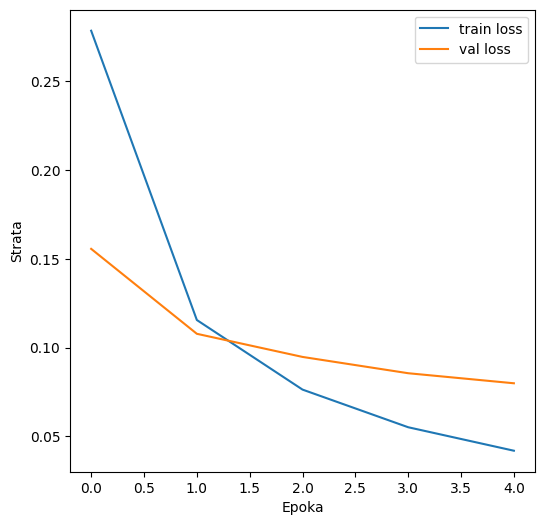

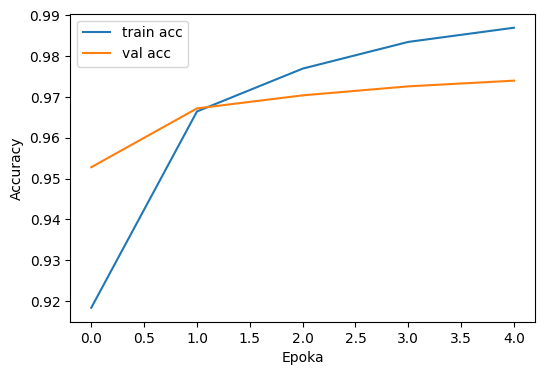

In [11]:
history = train(model1, val_loader, train_loader)

loss_plot(history)
acc_plot(history)

Widać że po koło 2 epokach  model juz wiecej nie uczy sie dokladniejszemu rozpoznawaniu na danych walidacyjnych i liepiej modelu nie przeuczac

Ewaluacja

In [12]:
def evaluate(model, test_loader, device):
    all_preds, all_targets = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            logits = model(xb)
            preds = logits.argmax(1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(yb.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_targets)

    test_acc = (y_pred == y_true).mean()
    print(f"Test accuracy: {test_acc:.4f}")

    return y_pred, y_true

I rysujemy heatmap

In [13]:
def plot_confusion_matrix(y_true, y_pred):
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6,6))
  plt.imshow(cm, interpolation='nearest',cmap='Greens')
  plt.title("Confusion Matrix (MNIST)")
  plt.colorbar()
  tick_marks = np.arange(10)
  plt.xticks(tick_marks, tick_marks)
  plt.yticks(tick_marks, tick_marks)

  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], 'd'),
              horizontalalignment="center",
              color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('Prawdziwa klasa')
  plt.xlabel('Predykcja')
  plt.tight_layout()
  plt.show()

  print(classification_report(y_true, y_pred, digits=4))

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9751


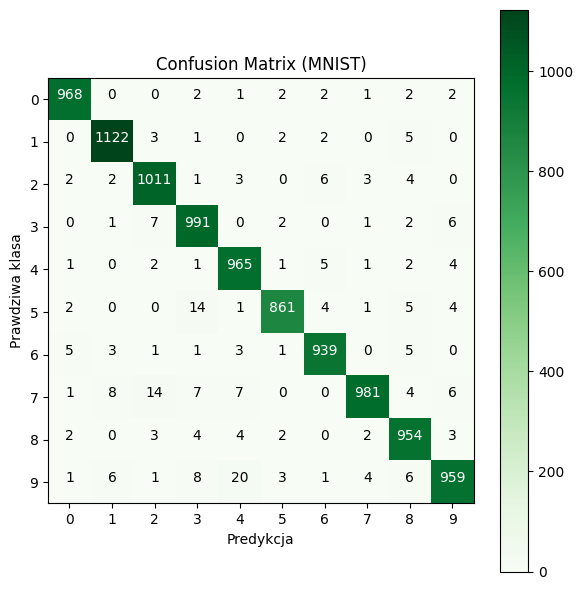

              precision    recall  f1-score   support

           0     0.9857    0.9878    0.9867       980
           1     0.9825    0.9885    0.9855      1135
           2     0.9702    0.9797    0.9749      1032
           3     0.9621    0.9812    0.9716      1010
           4     0.9612    0.9827    0.9718       982
           5     0.9851    0.9652    0.9751       892
           6     0.9791    0.9802    0.9797       958
           7     0.9869    0.9543    0.9703      1028
           8     0.9646    0.9795    0.9720       974
           9     0.9746    0.9504    0.9624      1009

    accuracy                         0.9751     10000
   macro avg     0.9752    0.9749    0.9750     10000
weighted avg     0.9752    0.9751    0.9751     10000



In [18]:
y_pred, y_true = evaluate(model1, test_loader, device)
plot_confusion_matrix(y_true, y_pred)

Wizualizacja predykcji

In [19]:
def visualize_predictions(model, test_loader, device):
  model.eval()
  images, labels = next(iter(test_loader))
  images, labels = images[:8], labels[:8]
  with torch.no_grad():
      logits = model(images.to(device))
  preds = logits.argmax(1).cpu()

  fig, axes = plt.subplots(1, len(images), figsize=(12, 2.5))
  for ax, img, y, p in zip(axes, images, labels, preds):
      ax.imshow(img.squeeze().numpy(), cmap="gray")
      ax.set_title(f"y={y.item()} / p={int(p)}")
      ax.axis("off")
  plt.show()

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


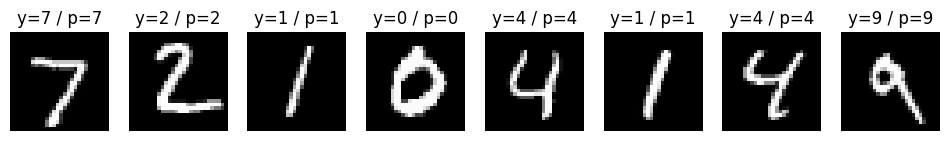

In [21]:
visualize_predictions(model1, test_loader, device)

Na razie tyle do MLP i przejdziemy do drugiego docelowego modelu i porównamy wyniki

# Prosty CNN

# Model 2

Na początku zrobiłam zwykły model z notatnika i za drugim razem zwiększyłam wyjscie i dodałam batch i polepszyło to wyniki

In [34]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)

        self.pool  = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1  = nn.Linear(128 * 7 * 7, 256)
        self.fc2  = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model2 = SimpleCNN().to(device)

In [35]:
history = train(model2, val_loader, train_loader)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Ep 01/5 | train loss 0.1685 acc 0.9471 | val loss 0.0551 acc 0.9840
Ep 02/5 | train loss 0.0535 acc 0.9838 | val loss 0.0439 acc 0.9864
Ep 03/5 | train loss 0.0398 acc 0.9873 | val loss 0.0383 acc 0.9884
Ep 04/5 | train loss 0.0305 acc 0.9900 | val loss 0.0372 acc 0.9892
Ep 05/5 | train loss 0.0250 acc 0.9920 | val loss 0.0368 acc 0.9876
Czas treningu: 967.7s


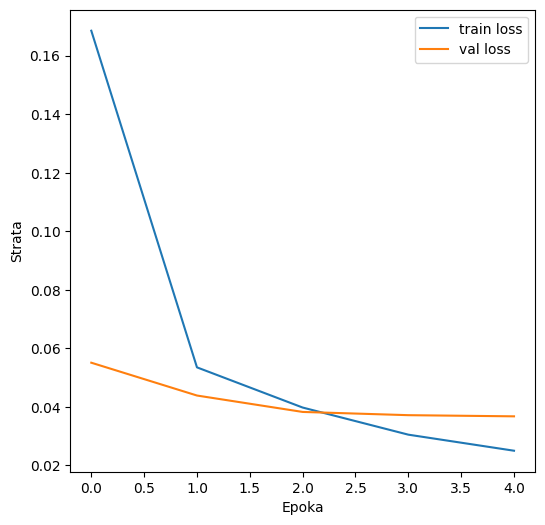

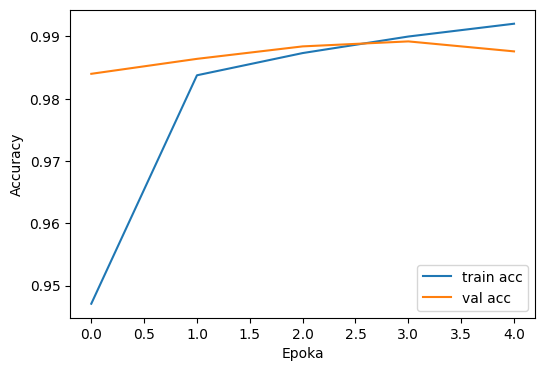

In [36]:
loss_plot(history)
acc_plot(history)

Na tych wykresach  widać że model uczy się dobrze model i również że n ie ma przeuczenia sie , co uważam za bardzo wynik, i jest lepszy od pierwszego modelu

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test accuracy: 0.9889


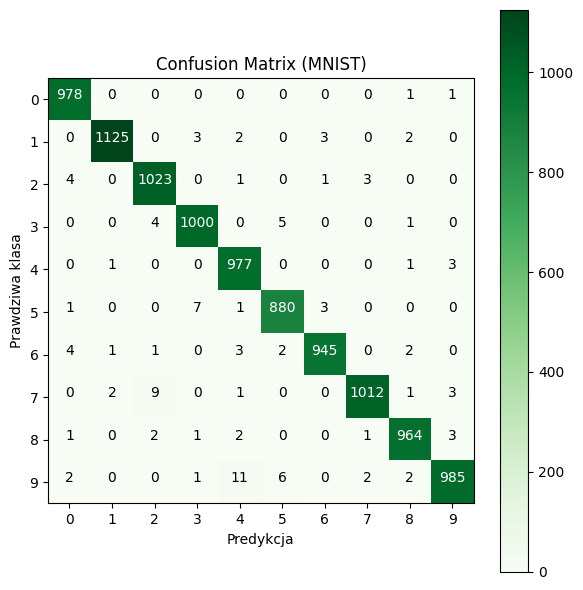

              precision    recall  f1-score   support

           0     0.9879    0.9980    0.9929       980
           1     0.9965    0.9912    0.9938      1135
           2     0.9846    0.9913    0.9879      1032
           3     0.9881    0.9901    0.9891      1010
           4     0.9790    0.9949    0.9869       982
           5     0.9854    0.9865    0.9860       892
           6     0.9926    0.9864    0.9895       958
           7     0.9941    0.9844    0.9892      1028
           8     0.9897    0.9897    0.9897       974
           9     0.9899    0.9762    0.9830      1009

    accuracy                         0.9889     10000
   macro avg     0.9888    0.9889    0.9888     10000
weighted avg     0.9889    0.9889    0.9889     10000



In [52]:
y_pred, y_true = evaluate(model2, test_loader, device)
plot_confusion_matrix(y_true, y_pred)

Ten model przez powiekszone wyjscia robil sie strasznie długo więc dalej juz robiłam na domyslnych

Również sprawdzam jak poradzi siebie model z większa ilością warstw i jak to wpłynie na wynik końcowy

# Model 3  - trzy warstwy

In [50]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.bn1(x)
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.bn2(x)
        x = self.pool3(F.relu(self.conv3(x)))
        x = self.bn3(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model3 = SimpleCNN().to(device)

Ep 01/5 | train loss 0.0151 acc 0.9951 | val loss 0.0350 acc 0.9912
Ep 02/5 | train loss 0.0068 acc 0.9976 | val loss 0.0360 acc 0.9904
Ep 03/5 | train loss 0.0075 acc 0.9975 | val loss 0.0485 acc 0.9902
Ep 04/5 | train loss 0.0099 acc 0.9968 | val loss 0.0339 acc 0.9912
Ep 05/5 | train loss 0.0062 acc 0.9979 | val loss 0.0428 acc 0.9898
Czas treningu: 524.6s


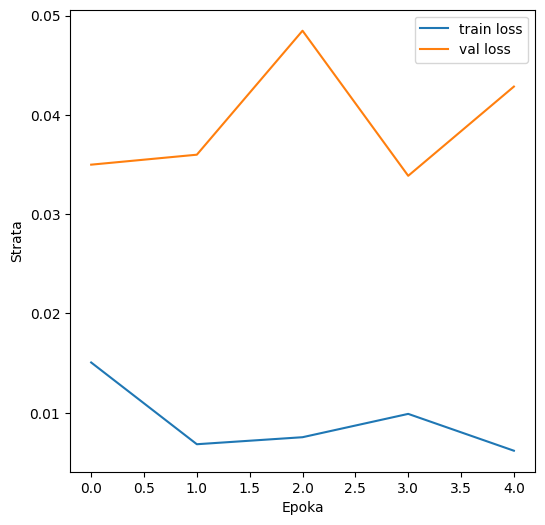

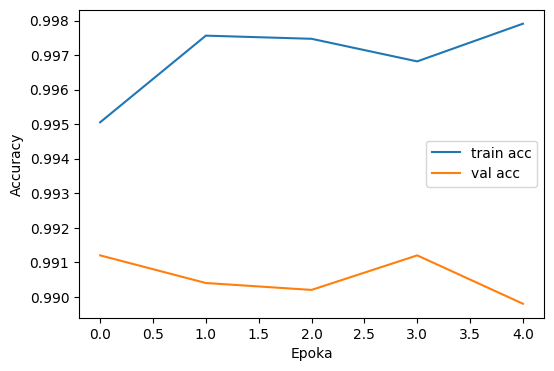

In [54]:
history = train(model3, val_loader, train_loader)
loss_plot(history)
acc_plot(history)

Tu widzimy na wykresach potężne przeuczenie się - zbyt utrudnilismy model i nie dalo to dobrego wyniku, mimo ze val accuracy i pokazuje 0.9898 nie oznacza to ze model dziala dobrze i zawsze warto to sprawdzac.

Jeszcze zachowam te modele

In [56]:
model_save_path = 'simple_nn_state_dict.pth'
torch.save(model1.state_dict(), model_save_path)

In [57]:
model_save_path = 'simple_nn_state_dict.pth'
torch.save(model2.state_dict(), model_save_path)

In [58]:
model_save_path = 'simple_nn_state_dict.pth'
torch.save(model3.state_dict(), model_save_path)

Model CNN pokazał że jest lepszym wyborem do takiego uczenia sie - ma lepsze wyniki i nie ma takiego ryzyko przeuczania sie jak MLP, chyba ze sie da niepotrzebnie dużo warstw i utrudni się model, co jak widac nie zawsze daje lepsze wyniki lecz naodwrot. Najliepiej siebie poradzily dwuwarstwowe na podstawowych oraz powiększonych wyjsciach - nie doszlo do przeuczenia się i pokazywało doskonałe wyniki.